In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

# 1. Загрузка данных
data = pd.read_csv('Main_комментарии.csv')  # путь к вашему файлу с данными

# Проверка доступных столбцов
available_columns = data.columns.tolist()
print("Доступные столбцы:", available_columns)

# Обновляем список categories, оставляя только те, которые есть в данных
categories = [col for col in [
    'Вопрос решен',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки',
    'Другое'
] if col in data.columns]

print("Используемые категории:", categories)

# Если нет ни одной категории - ошибка
if not categories:
    raise ValueError("В данных отсутствуют все указанные категории. Проверьте CSV-файл.")

# Продолжаем обработку с исправленным списком categories
labels = data[categories].values.astype(int)

# Стратифицированная выборка по одному из наиболее сбалансированных признаков (если есть)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['comment'].values,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels.argmax(axis=1)  # предполагается, что есть баланс по классам
)

# 3. Токенизация и подготовка датасета
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class CommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.FloatTensor(label)
        }

train_dataset = CommentsDataset(train_texts, train_labels, tokenizer)
val_dataset = CommentsDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# 4. Модель с несколькими выходами (multi-label)
class BertMultiLabelClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super(BertMultiLabelClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=False)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, len(categories))
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # [batch_size, hidden_size]
        pooled_output = self.dropout(pooled_output)
        logits= self.classifier(pooled_output)  # [batch_size, num_classes]
        return logits

model= BertMultiLabelClassifier()
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 5. Обучение с планировщиком lr и клиппингом градиентов
criterion= nn.BCEWithLogitsLoss()
optimizer= optim.AdamW(model.parameters(), lr=2e-5)


num_epochs=4  # увеличьте число эпох для лучшего обучения

total_steps= len(train_loader)*num_epochs

scheduler= get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1*total_steps),
    num_training_steps=total_steps
)

for epoch in range(num_epochs):
    model.train()
    total_loss=0
    for batch in train_loader:
        input_ids= batch['input_ids'].to(device)
        attention_mask= batch['attention_mask'].to(device)
        labels= batch['labels'].to(device)

        optimizer.zero_grad()
        outputs= model(input_ids=input_ids, attention_mask=attention_mask)
        loss= criterion(outputs, labels)
        loss.backward()

        # градиентный клиппинг для стабилизации обучения
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        total_loss+= loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

c:\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Доступные столбцы: ['id', 'rating', 'comment', 'Нравится скорость отработки заявок', 'Нравится качество выполнения заявки', 'Нравится качество работы сотрудников', 'Понравилось выполнение заявки', 'Вопрос решен', 'Без категории']
Используемые категории: ['Вопрос решен', 'Нравится качество выполнения заявки', 'Нравится качество работы сотрудников', 'Нравится скорость отработки заявок', 'Понравилось выполнение заявки']
Epoch 1/4, Loss: 0.5110
Epoch 2/4, Loss: 0.2750
Epoch 3/4, Loss: 0.2052
Epoch 4/4, Loss: 0.1710


F1-score (macro): 0.6874
F1-score (micro): 0.9276
F1-score для 'Вопрос решен': 0.1875
F1-score для 'Нравится качество выполнения заявки': 0.9798
F1-score для 'Нравится качество работы сотрудников': 0.3226
F1-score для 'Нравится скорость отработки заявок': 0.9666
F1-score для 'Понравилось выполнение заявки': 0.9807
--------------------------------------------------------------------------
ROC-AUC для 'Вопрос решен': 0.8832467532467533
ROC-AUC для 'Нравится качество выполнения заявки': 0.9907910218119286
ROC-AUC для 'Нравится качество работы сотрудников': 0.9361406534444763
ROC-AUC для 'Нравится скорость отработки заявок': 0.9911844752100343
ROC-AUC для 'Понравилось выполнение заявки': 0.9918336886993603
Средний ROC-AUC по классам: 0.9586


C:\Users\Mrsoning\AppData\Local\Temp\ipykernel_1668\1797460994.py:97: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mrsoning\AppData\Local\Temp\ipykernel_1668\1797460994.py:97: UserWarning: Glyph 127996 (\N{EMOJI MODIFIER FITZPATRICK TYPE-3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mrsoning\AppData\Local\Temp\ipykernel_1668\1797460994.py:97: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\Mrsoning\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Mrsoning\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127996 (\N{EMOJI MODIFIER FITZPATRICK TYPE-3}) missing from font(s) DejaVu Sans.
  f

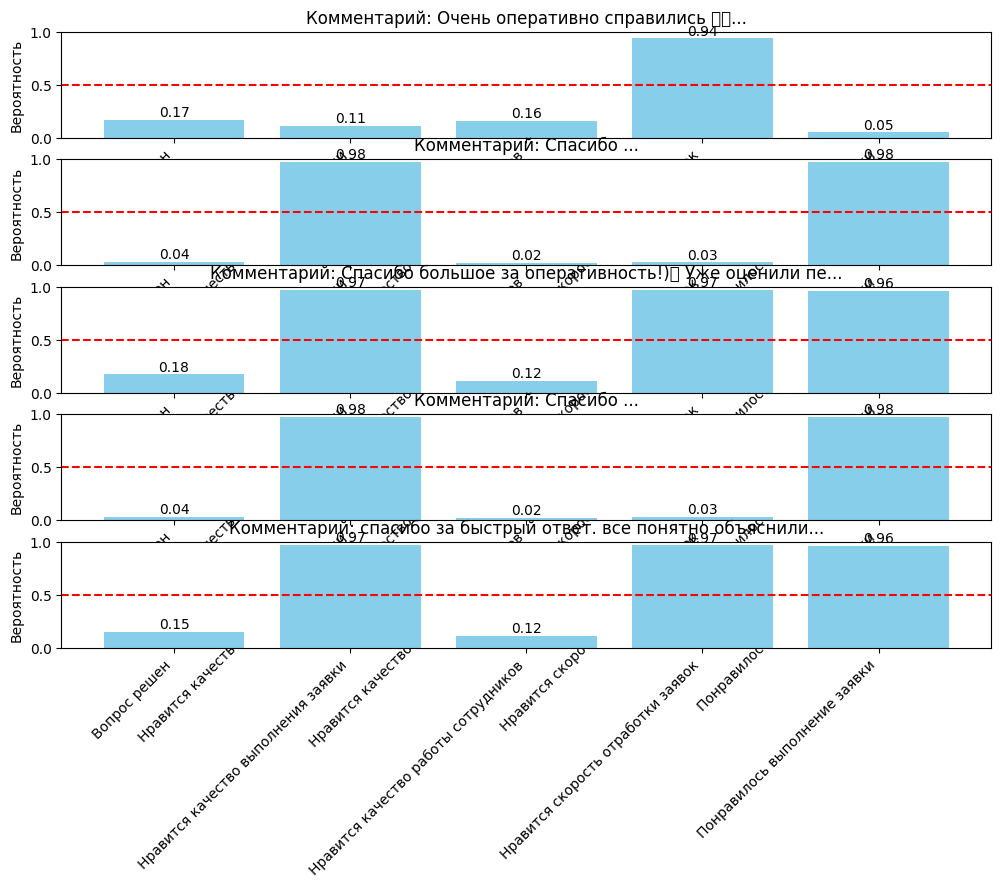

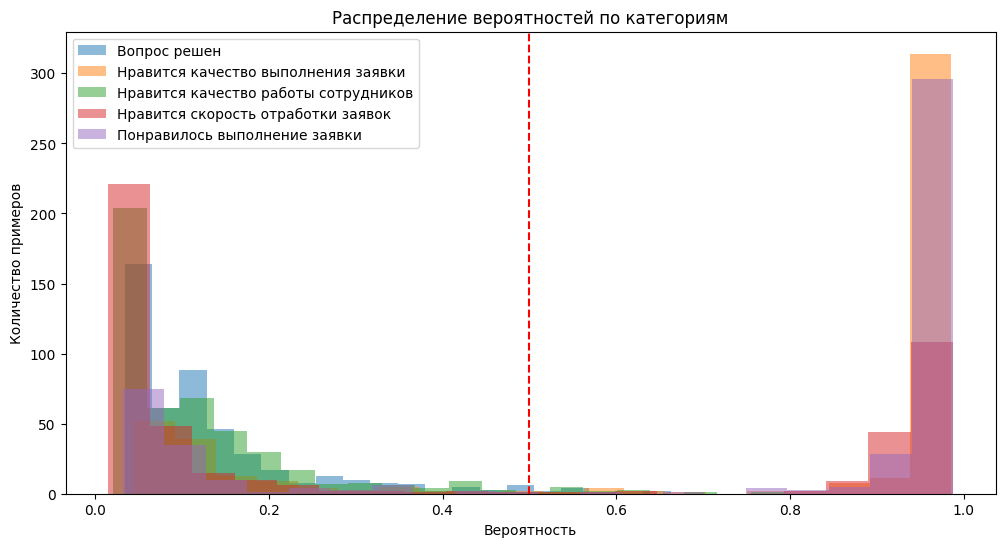

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score

model.eval()
all_preds = []
all_true = []

threshold = 0.5

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.sigmoid(outputs).cpu().numpy()

        all_preds.extend(preds)
        all_true.extend(labels)

true_labels = np.array(all_true)
preds_array = np.array(all_preds)

# Бинарные предсказания
pred_labels = preds_array >= threshold

# F1-score (macro и micro)
f1_macro = f1_score(true_labels, pred_labels, average='macro')
f1_micro = f1_score(true_labels, pred_labels, average='micro')

print(f"F1-score (macro): {f1_macro:.4f}")
print(f"F1-score (micro): {f1_micro:.4f}")

# Вывод F1-score для каждого класса
for i, category in enumerate(categories):
    f1_class = f1_score(true_labels[:, i], pred_labels[:, i])
    print(f"F1-score для '{category}': {f1_class:.4f}")

print('--------------------------------------------------------------------------')

# Расчет ROC-AUC по каждому классу
roc_auc_scores = []
for i, category in enumerate(categories):
    try:
        score = roc_auc_score(true_labels[:, i], preds_array[:, i])
    except ValueError as e:
        score = None
        print(f"ROC-AUC для '{category}': недоступен ({e})")
    roc_auc_scores.append(score)

# Вывод ROC-AUC по классам
for i, category in enumerate(categories):
    score = roc_auc_scores[i]
    print(f"ROC-AUC для '{category}': {score if score is not None else 'недоступен'}")

# Средний ROC-AUC по классам
valid_scores = [score for score in roc_auc_scores if score is not None]
if valid_scores:
    roc_auc_mean = np.mean(valid_scores)
    print(f"Средний ROC-AUC по классам: {roc_auc_mean:.4f}")
else:
    print("Нет доступных значений ROC-AUC для вычисления среднего.")

# Визуализация вероятностей принадлежности к категориям
plt.figure(figsize=(12, 8))

# Выбираем случайные 5 примеров для визуализации
sample_indices = np.random.choice(len(val_texts), min(5, len(val_texts)), replace=False)

for i, idx in enumerate(sample_indices):
    plt.subplot(len(sample_indices), 1, i+1)
    
    # Получаем вероятности для данного примера
    probs = preds_array[idx]
    
    # Создаем bar plot
    bars = plt.bar(range(len(categories)), probs, color='skyblue')
    
    # Подписываем столбцы
    plt.xticks(range(len(categories)), categories, rotation=45, ha='right')
    plt.ylabel('Вероятность')
    plt.title(f'Комментарий: {val_texts[idx][:50]}...')
    plt.ylim(0, 1)
    
    # Добавляем горизонтальную линию для порога
    plt.axhline(y=threshold, color='r', linestyle='--')
    
    # Подписываем значения на столбцах
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Дополнительная визуализация: распределение вероятностей по всем категориям
plt.figure(figsize=(12, 6))
for i, category in enumerate(categories):
    plt.hist(preds_array[:, i], bins=20, alpha=0.5, label=category)
plt.xlabel('Вероятность')
plt.ylabel('Количество примеров')
plt.title('Распределение вероятностей по категориям')
plt.legend()
plt.axvline(x=threshold, color='r', linestyle='--', label='Порог')
plt.show()